In [1]:
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from keras import backend as K
from keras.layers import Dense, Activation, Input, concatenate,Lambda,GaussianNoise
from keras.models import Model, load_model
from keras.optimizers import Adam
from IPython.display import clear_output

from warnings import filterwarnings
filterwarnings('ignore')


import seaborn as sns
sns.set_context("paper")
sns.set_style("darkgrid")

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Using TensorFlow backend.


In [2]:
#MountainCarContinuous-v0
#Pendulum-v0
#BipedalWalker-v2
#LunarLanderContinuous-v2 env._max_episode_steps=2000
#Acrobot-v1
env=gym.make("Pendulum-v0")
env.reset()
state_dim = env.observation_space.shape
lower_bound_action,upper_bound_action=env.action_space.low,env.action_space.high
n_actions = lower_bound_action.shape[0]

# REINFORCE with linear approximators

In [3]:
class REINFORCE(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        
        self.alpha_mu=paras['alpha_mu']
        self.paras_mu=np.zeros((self.dim_state,self.num_action))
        self.alpha_sigma=paras['alpha_sigma']
        self.paras_sigma=np.zeros((self.dim_state,self.num_action))
        self.gamma=0.999

    def pi(self,s,a):
        mu=self.get_mu(s)
        sigma=self.get_sigma(s)
        pi=np.exp(0.5*((mu-a)/(sigma))**2)/(sigma*np.sqrt(2*np.pi))
        return pi
        
    def get_mu(self,s):
        return s.dot(self.paras_mu)
    
    def get_sigma(self,s):
        return np.exp(s.dot(self.paras_sigma))
    
    def get_actions(self,s):
        mu=self.get_mu(s)
        sigma=self.get_sigma(s)
        a=np.random.normal(mu,sigma)  
        a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        return a
        
    def update_paras(self,states,actions,rewards):
        T=len(states)
        rewards=np.array(rewards)
        rewards=(rewards-rewards.min()+1e-10)/(rewards.max()-rewards.min()+1e-10)
        for t in range(T):
            G=sum([rewards[k]*(self.gamma**(k-t-1)) for k in range(t+1,T)])
            a=actions[t]
            s=states[t]
            prob=self.pi(s,a)
            mu=self.get_mu(s)
            sigma=self.get_sigma(s)
            
            d_mu=s.reshape(-1,1).dot(((1/sigma**2)*(a-mu)).reshape(1,-1))
            d_sigma=s.reshape(-1,1).dot(((((a-mu)/sigma)**2)-1).reshape(1,-1))
            
            self.paras_mu+=self.alpha_mu*(self.gamma**t)*G*d_mu
            self.paras_sigma+=self.alpha_sigma*(self.gamma**t)*G*d_sigma

50 -19.950736006891162
100 -8.421883439131285
150 -9.579695302780996
200 -9.38472208761539


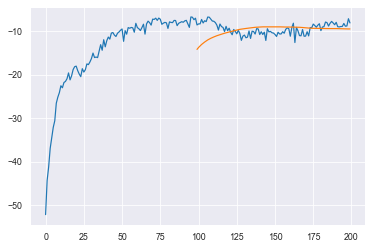

In [4]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['alpha_mu']=1e-5
agent_config['alpha_sigma']=1e-5
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent=REINFORCE(agent_config)

Iter=200
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    states=[]
    actions=[]
    rewards=[]
    while not done:
        a = agent.get_actions(s)
        sp, r, done, info = env.step(a)
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s = sp
        G+=r
    G_log.append(G)
    agent.update_paras(states,actions,rewards)
    
    if (epoch+1)%50==0:
        print(epoch+1,np.mean(G_log[-50:]))
plt.plot(G_log)
plt.plot(pd.DataFrame(G_log).rolling(100).mean())
plt.show()            

# REINFORCE with nonlinear approximators

In [5]:
class approximator(nn.Module):
    def __init__(self,paras):
        super(approximator, self).__init__()
        self.input_dim=paras['dim_state']
        self.output_dim=paras['num_action']
        self.alpha_policy=paras['alpha_policy']
        self.structure_policy=paras['structure_policy']
        
        self.structure=[]
        for idx,layer in enumerate(self.structure_policy[:-1]):
            if idx==0:
                self.structure.append(nn.Linear(self.input_dim,layer))
                self.structure.append(nn.Linear(layer,self.structure_policy[idx+1]))
            else:
                self.structure.append(nn.Linear(layer,self.structure_policy[idx+1]))
        self.structure.append([nn.Linear(self.structure_policy[-1],self.output_dim),nn.Linear(self.structure_policy[-1],self.output_dim)])
        self.myparameters=nn.ModuleList(self.structure[:-1]+[self.structure[-1][0],self.structure[-1][0]])
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha_policy)
        
    def forward(self, x):
        x = T.tensor(x, dtype=T.float)
        for idx,layer in enumerate(self.structure[:-1]):
            x=F.relu(layer(x))
        mu=self.structure[-1][0](x)
        sigma=T.exp(self.structure[-1][1](x))
        return mu,sigma

In [6]:
class REINFORCE_NN(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        
        self.gamma=0.99999
        self.approximator=approximator(paras)
    
    def get_actions(self,s):
        mu,sigma=self.approximator.forward(s)
        mu=mu.detach().numpy()
        sigma=sigma.detach().numpy()
        a=np.random.normal(mu,sigma)  
        a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        return a 
    
    def update_paras(self,states,actions,rewards):
        G=np.array([sum([rewards[k]*(self.gamma**(k-t-1)) for k in range(t+1,len(states))]) for t in range(len(states))])
        s=np.array([list(states[idx][0]) for idx in range(len(states))])
        a=np.array([list(actions[idx][0]) for idx in range(len(actions))])        
        gammas=np.array([self.gamma**t for t in range(len(states))])
        G*=gammas
        G=(G-G.min()+1e-10)/(G.max()-G.min()+1e-10)
        
        mu,sigma=self.approximator.forward(s)
        action_probs = T.distributions.Normal(mu, sigma)
        a = T.tensor(a, dtype=T.float)
        G = T.tensor(G, dtype=T.float)
        log_probs = action_probs.log_prob(a)        
        self.approximator_loss = -log_probs*G
        self.approximator.optimizer.zero_grad()
        self.approximator_loss.sum().backward()
        self.approximator.optimizer.step()

In [ ]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_policy']=1e-3
agent_config['structure_policy']=[64,32]
agent=REINFORCE_NN(agent_config)

Iter=200
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    states=[]
    actions=[]
    rewards=[]
    while not done:
        a = agent.get_actions(s.reshape(1,-1))
        sp, r, done, info = env.step(a)
        states.append(s.reshape(1,-1))
        actions.append(a)
        rewards.append(r)
        s = sp
        G+=r
    G_log.append(G)
    agent.update_paras(states,actions,rewards)
    if (epoch+1)%50==0:
        print(epoch+1,np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()            

# REINFORCE with nonlinear approximators & baseline

In [8]:
class approximator_baseline(nn.Module):
    def __init__(self,paras):
        super(approximator_baseline, self).__init__()
        self.input_dim=paras['dim_state']
        self.output_dim=paras['num_action']
        self.alpha_policy=paras['alpha_policy']
        self.structure_policy=paras['structure_policy']
        
        self.structure=[]
        for idx,layer in enumerate(self.structure_policy[:-1]):
            if idx==0:
                self.structure.append(nn.Linear(self.input_dim,layer))
                self.structure.append(nn.Linear(layer,self.structure_policy[idx+1]))
            else:
                self.structure.append(nn.Linear(layer,self.structure_policy[idx+1]))
        self.structure.append([nn.Linear(self.structure_policy[-1],self.output_dim),nn.Linear(self.structure_policy[-1],self.output_dim)])
        self.myparameters=nn.ModuleList(self.structure[:-1]+[self.structure[-1][0],self.structure[-1][0]])
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha_policy)
        
    def forward(self, x):
        x = T.tensor(x, dtype=T.float)
        for idx,layer in enumerate(self.structure[:-1]):
            x=F.relu(layer(x))
        mu=self.structure[-1][0](x)
        sigma=T.exp(self.structure[-1][1](x))
        return mu,sigma

In [9]:
class REINFORCE_baseline_NN(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        
        self.gamma=0.99999
        self.approximator=approximator_baseline(paras)
        self.baseline=self.get_baseline(paras)
        
    def get_baseline(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(paras['structure_baseline']):
            if idx==0:
                dense_layers = [Dense(layer, activation='relu')(state)]
            else:
                dense_layers.append(Dense(layer, activation='relu')(dense_layers[-1]))
        value = Dense(1, activation='linear')(dense_layers[-1])
        baseline = Model(input=[state], output=[value])
        baseline.compile(optimizer=Adam(lr=paras['alpha_baseline']), loss="mse")
        return baseline
    
    def get_actions(self,s):
        mu,sigma=self.approximator.forward(s)
        mu=mu.detach().numpy()
        sigma=sigma.detach().numpy()
        a=np.random.normal(mu,sigma)  
        a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        return a 
    
    def update_paras(self,states,actions,rewards):
        G=np.array([sum([rewards[k]*(self.gamma**(k-t-1)) for k in range(t+1,len(states))]) for t in range(len(states))])
        s=np.array([list(states[idx][0]) for idx in range(len(states))])
        a=np.array([list(actions[idx][0]) for idx in range(len(actions))])        
        gammas=np.array([self.gamma**t for t in range(len(states))])
        v_s=self.baseline.predict(s)
        G=(G-G.min()+1e-10)/(G.max()-G.min()+1e-10)
        delta=G.reshape(-1,1)-v_s
        self.baseline.fit(s,delta,verbose=False)
        
        delta=delta.T
        delta*=gammas
        mu,sigma=self.approximator.forward(s)
        action_probs = T.distributions.Normal(mu, sigma)
        a = T.tensor(a, dtype=T.float)
        delta = T.tensor(delta, dtype=T.float)
        log_probs = action_probs.log_prob(a)        
        self.approximator_loss = -log_probs*delta
        self.approximator.optimizer.zero_grad()
        self.approximator_loss.sum().backward()
        self.approximator.optimizer.step()
        
        

In [ ]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_policy']=1e-5
agent_config['structure_policy']=[256,128]
agent_config['alpha_baseline']=1e-3
agent_config['structure_baseline']=[256,128]


agent=REINFORCE_baseline_NN(agent_config)

Iter=200
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    states=[]
    actions=[]
    rewards=[]
    while not done:
        a = agent.get_actions(s.reshape(1,-1))
        sp, r, done, info = env.step(a)
        states.append(s.reshape(1,-1))
        actions.append(a)
        rewards.append(r)
        s = sp
        G+=r
    G_log.append(G)
    agent.update_paras(states,actions,rewards)
    if (epoch+1)%50==0:
        print(epoch+1,np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()            

# Actor-Critic

In [12]:
class Actor(nn.Module):
    def __init__(self,paras):
        super(Actor, self).__init__()
        self.input_dim=paras['dim_state']
        self.output_dim=paras['num_action']
        self.alpha_actor=paras['alpha_actor']
        self.structure_actor=paras['structure_actor']
        
        self.structure=[]
        for idx,layer in enumerate(self.structure_actor[:-1]):
            if idx==0:
                self.structure.append(nn.Linear(self.input_dim,layer))
                self.structure.append(nn.Linear(layer,self.structure_actor[idx+1]))
            else:
                self.structure.append(nn.Linear(layer,self.structure_actor[idx+1]))
        self.structure.append([nn.Linear(self.structure_actor[-1],self.output_dim),nn.Linear(self.structure_actor[-1],self.output_dim)])
        self.myparameters=nn.ModuleList(self.structure[:-1]+[self.structure[-1][0],self.structure[-1][0]])
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha_actor)
        
    def forward(self, x):
        x = T.tensor(x, dtype=T.float)
        for idx,layer in enumerate(self.structure[:-1]):
            x=F.relu(layer(x))
        mu=self.structure[-1][0](x)
        sigma=T.exp(self.structure[-1][1](x))
        return mu,sigma

class AC(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        
        self.gamma=0.99999
        self.actor=Actor(paras)
        self.critic=self.Critic(paras)
        
    def Critic(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(paras['structure_critic']):
            if idx==0:
                dense_layers = [Dense(layer, activation='relu')(state)]
            else:
                dense_layers.append(Dense(layer, activation='relu')(dense_layers[-1]))
        value = Dense(1, activation='linear')(dense_layers[-1])
        critic = Model(input=[state], output=[value])
        critic.compile(optimizer=Adam(lr=paras['alpha_critic']), loss="mse")
        return critic
    
    def get_actions(self,s):
        mu,sigma=self.actor.forward(s)
        mu=mu.detach().numpy()
        sigma=sigma.detach().numpy()
        a=np.random.normal(mu,sigma)  
        a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        return a 
    
    def update_paras(self,s,a,r,sp,done,gamma):
        v_s=self.critic.predict(s)
        v_sp=self.critic.predict(sp)
        target=r+self.gamma*v_sp*(not done)
        delta=target-v_s
        self.critic.fit(s,target,verbose=False)
        
        delta*=gamma
        mu,sigma=self.actor.forward(s)
        action_probs = T.distributions.Normal(mu, sigma)
        a = T.tensor(a, dtype=T.float)
        delta = T.tensor(delta, dtype=T.float)
        log_probs = action_probs.log_prob(a)        
        self.actor_loss = -log_probs*delta
        self.actor.optimizer.zero_grad()
        self.actor_loss.sum().backward()
        self.actor.optimizer.step()

In [ ]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=1e-7
agent_config['structure_actor']=[256,128]
agent_config['alpha_critic']=1e-5
agent_config['structure_critic']=[256,128]
agent=AC(agent_config)

Iter=200
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    gamma=1
    while not done:
        a = agent.get_actions(s.reshape(1,-1))
        sp, r, done, info = env.step(a[0])
        agent.update_paras(s.reshape(1,-1),a,r,sp.reshape(1,-1),done,gamma)
        gamma*=agent.gamma
        s = sp
        G+=r
    G_log.append(G)
    print(G)
    if (epoch+1)%10==0:
        print(epoch+1,np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()            

# DDPG

In [3]:
class DDPG(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        self.gamma=0.99999
        
        self.actor=self.Actor(paras)
        self.target_actor=self.Actor(paras)
        self.update_weights(self.target_actor,self.actor)
        
        
        self.critic=self.Critic(paras)
        self.target_critic=self.Critic(paras,Target=True)
        self.update_weights(self.target_critic,self.critic)
        
        
        self.sigma=self.upper_bound_action-self.lower_bound_action
        self.memory=[]
        self.memory_size=paras['memory_size']
        self.batch_size=paras['batch_size']
        self.update_freq=paras['update_freq']
        self.sigma_decay=paras['sigma_decay'] 
        self.polyak=paras['polyak']
        self.count=0
        self.pure_explore_step=paras['pure_explore_step']
        self.start_learning_step=paras['start_learning_step']
        
    def Actor(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(agent_config['structure_actor']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(state))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        mu = Dense(self.num_action, activation='tanh')(dense_layers[-1])
        mu = Lambda(lambda i: i * self.upper_bound_action)(mu)
        
        actor = Model(inputs=[state], outputs=[mu])
        actor.compile(optimizer=Adam(lr=agent_config['alpha_actor']), loss="mse")
        return actor
        
    def Critic(self,paras,Target=False):
        state = Input(shape=[self.dim_state,])
        action = Input(shape=[self.num_action,])
        combined = concatenate([state, action])
        for idx,layer in enumerate(agent_config['structure_critic']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(combined))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        value = Dense(1, activation='linear')(dense_layers[-1])
        Q_s_a = Model(inputs=[state,action], outputs=[value])
        Q_s_a.compile(optimizer=Adam(lr=agent_config['alpha_critic']), loss="mse")
        
        if not Target:
            gradient = K.gradients(Q_s_a.output, Q_s_a.input)[1]
            self.get_grad = K.function(Q_s_a.input, [gradient])
        return Q_s_a

    def memorize(self,s,a,r,sp,done):
        self.memory.append([s,a,r,sp,done])
        if len(self.memory)>self.memory_size:
            del self.memory[0] 
    
    def sample_exp(self):
        index_set=np.random.choice(range(len(self.memory)),
                    size=min(len(self.memory),self.batch_size),replace=False)
        return np.array(self.memory)[index_set]
     
    def learn(self):        
        self.count+=1
        if self.count%self.update_freq==0 and len(self.memory)>=self.start_learning_step:
            sampled_exp=self.sample_exp()
            s=np.array([list(_) for _ in sampled_exp[:,0]])
            a=np.array([list(_) for _ in sampled_exp[:,1]])
            r=sampled_exp[:,2].reshape(-1,1)
            sp=np.array([list(_) for _ in sampled_exp[:,3]])
            done=sampled_exp[:,4].reshape(-1,1)
            self.update_paras(s,a,r,sp,done)
            if len(self.memory)>=self.pure_explore_step:
                self.sigma*=self.sigma_decay 
                self.sigma[self.sigma<=1e-5]=1e-5
    
    def get_actions(self,s,train=True):
        if len(self.memory)<=self.pure_explore_step and train:
            a=np.random.random(size=(1,self.num_action))*(self.upper_bound_action-self.lower_bound_action)
        elif train:
            sigma=self.sigma
            mu=self.actor.predict(s)
            a=mu+np.random.normal(np.zeros(self.num_action),sigma)  
            a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        else:
            a=self.actor.predict(s)
        return a 
    
    def update_weights(self,update_target,update_source,polyak=0):
        old_weight=update_target.get_weights()
        new_weight=update_source.get_weights()
        weight=[polyak*old_weight[idx]+(1-polyak)*new_weight[idx] for idx in range(len(new_weight))]
        update_target.set_weights(weight)
        
    def update_paras(self,s,a,r,sp,done):
        mup=self.target_actor.predict(sp)
        Q_sp_ap=self.target_critic.predict([sp,mup])
        target=r+self.gamma*Q_sp_ap*(1-done)
        mu=self.actor.predict(s)
        self.critic.fit([s,a],target,verbose=False) 
        
        
        d_mu=self.get_grad([s,mu])[0]
        self.actor.fit(s,mu+d_mu,verbose=False) 
        
        self.update_weights(self.target_actor,self.actor,self.polyak)
        self.update_weights(self.target_critic,self.critic,self.polyak)
        

In [ ]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=3e-3
agent_config['alpha_critic']=3e-3
agent_config['structure_actor']=[32,16]
agent_config['structure_critic']=[32,16]
agent_config['memory_size']=1e7
agent_config['batch_size']=32

agent_config['update_freq']=1
agent_config['sigma_decay']=0.999
agent_config['polyak']=0.99

agent_config['pure_explore_step']=10000
agent_config['start_learning_step']=5000

agent=DDPG(agent_config)

Iter=300
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    while not done:
        a = agent.get_actions(s.reshape(1,-1))[0]
        sp, r, done, info = env.step(a)
        agent.memorize(s,a,r,sp,done)
        agent.learn()
        s = sp
        G+=r
    G_log.append(G)
    print(len(G_log),G,agent.sigma,len(agent.memory))
    if (epoch+1)%10==0:
        print(len(G_log),np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()  

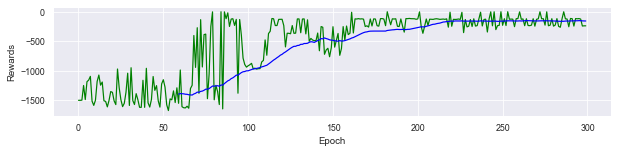

In [8]:
plt.figure(figsize=(10,2))
plt.plot(G_log,c="green")
plt.plot(pd.DataFrame(G_log).rolling(int(len(G_log)/5)).mean(),c="blue")
plt.xlabel("Epoch")
plt.ylabel("Rewards")
plt.show()

# TD3: Twin Delayed DDPG

In [9]:
class TD3(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        self.gamma=0.99999
        
        self.actor=self.Actor(paras)
        self.target_actor=self.Actor(paras)
        self.update_weights(self.target_actor,self.actor)
        
        self.critic_1=self.Critic(paras)
        self.critic_2=self.Critic(paras)
        self.target_critic_1=self.Critic(paras,Target=True)
        self.target_critic_2=self.Critic(paras,Target=True)
        self.update_weights(self.target_critic_1,self.critic_1)
        self.update_weights(self.target_critic_2,self.critic_2)
        
        self.sigma=self.upper_bound_action-self.lower_bound_action
        self.memory=[]
        self.memory_size=paras['memory_size']
        self.batch_size=paras['batch_size']
        self.update_freq=paras['update_freq']
        self.sigma_decay=paras['sigma_decay'] 
        self.polyak=paras['polyak']
        self.count=0
        self.Q_update_count=0
        self.policy_delay=paras['policy_delay']
        self.pure_explore_step=paras['pure_explore_step']
        self.start_learning_step=paras['start_learning_step']
        
    def Actor(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(agent_config['structure_actor']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(state))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        mu = Dense(self.num_action, activation='tanh')(dense_layers[-1])
        mu = Lambda(lambda i: i * self.upper_bound_action)(mu)
        
        actor = Model(inputs=[state], outputs=[mu])
        actor.compile(optimizer=Adam(lr=agent_config['alpha_actor']), loss="mse")
        return actor
        
    def Critic(self,paras,Target=False):
        state = Input(shape=[self.dim_state,])
        action = Input(shape=[self.num_action,])
        combined = concatenate([state, action])
        for idx,layer in enumerate(agent_config['structure_critic']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(combined))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        value = Dense(1, activation='linear')(dense_layers[-1])
        Q_s_a = Model(inputs=[state,action], outputs=[value])
        Q_s_a.compile(optimizer=Adam(lr=agent_config['alpha_critic']), loss="mse")
        
        if not Target:
            gradient = K.gradients(Q_s_a.output, Q_s_a.input)[1]
            self.get_grad = K.function(Q_s_a.input, [gradient])
        return Q_s_a

    def memorize(self,s,a,r,sp,done):
        self.memory.append([s,a,r,sp,done])
        if len(self.memory)>self.memory_size:
            del self.memory[0] 
    
    def sample_exp(self):
        index_set=np.random.choice(range(len(self.memory)),
                    size=min(len(self.memory),self.batch_size),replace=False)
        return np.array(self.memory)[index_set]
     
    def learn(self):        
        self.count+=1
        if self.count%self.update_freq==0 and len(self.memory)>=self.start_learning_step:
            sampled_exp=self.sample_exp()
            s=np.array([list(_) for _ in sampled_exp[:,0]])
            a=np.array([list(_) for _ in sampled_exp[:,1]])
            r=sampled_exp[:,2].reshape(-1,1)
            sp=np.array([list(_) for _ in sampled_exp[:,3]])
            done=sampled_exp[:,4].reshape(-1,1)
            self.update_paras(s,a,r,sp,done)
            if len(self.memory)>=self.pure_explore_step:
                self.sigma*=self.sigma_decay 
                self.sigma[self.sigma<=1e-5]=1e-5
    
    def get_actions(self,s,train=True):
        if len(self.memory)<=self.pure_explore_step and train:
            a=np.random.random(size=(1,self.num_action))*(self.upper_bound_action-self.lower_bound_action)
        elif train:
            mu=self.actor.predict(s)
            a=mu+np.random.normal(np.zeros(self.num_action),self.sigma)  
            a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        else:
            a=self.actor.predict(s)
        return a 
    
    def update_weights(self,update_target,update_source,polyak=0):
        old_weight=update_target.get_weights()
        new_weight=update_source.get_weights()
        weight=[polyak*old_weight[idx]+(1-polyak)*new_weight[idx] for idx in range(len(new_weight))]
        update_target.set_weights(weight)
        
    
    def update_paras(self,s,a,r,sp,done):
        mup=self.target_actor.predict(sp)
        ap=mup+np.random.normal(np.zeros(self.num_action),self.sigma)  
        ap=np.clip(ap,self.lower_bound_action,self.upper_bound_action)

        Q_sp_ap_1=self.target_critic_1.predict([sp,ap])
        Q_sp_ap_2=self.target_critic_2.predict([sp,ap])
        
        Q_sp_ap=np.zeros((len(s),2))
        Q_sp_ap[:,0]=Q_sp_ap_1.reshape(-1,1)[:,0]
        Q_sp_ap[:,1]=Q_sp_ap_2.reshape(-1,1)[:,0]
        Q_sp_ap=np.min(Q_sp_ap,axis=1).reshape(-1,1)
        
        target=r+self.gamma*Q_sp_ap*(1-done)
        self.critic_1.fit([s,a],target,verbose=False) 
        self.critic_2.fit([s,a],target,verbose=False) 
        
        self.update_weights(self.target_critic_1,self.critic_1,self.polyak)
        self.update_weights(self.target_critic_2,self.critic_2,self.polyak)
        self.Q_update_count+=1
        
        if self.Q_update_count%self.policy_delay==0:
            mu=self.actor.predict(s)
            d_mu=self.get_grad([s,mu])[0]
            self.actor.fit(s,mu+d_mu,verbose=False) 
            self.update_weights(self.target_actor,self.actor,self.polyak)
            


1 -1192.8345299185585 [4.] 200
2 -1180.6175848954176 [4.] 400
3 -1104.48590447769 [4.] 600
4 -1414.9389844915186 [4.] 800
5 -1482.7838371210971 [4.] 1000
6 -1542.055853348567 [4.] 1200
7 -1618.5448738713794 [4.] 1400
8 -1174.30070830461 [4.] 1600
9 -1391.528220809124 [4.] 1800
10 -1459.3792637143383 [4.] 2000
10 -1356.14697609523


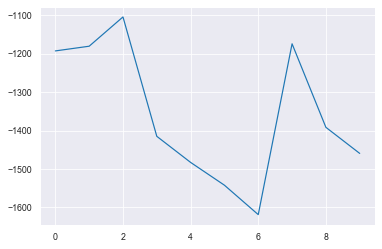

11 -1592.659026605833 [4.] 2200
12 -1594.0210936876983 [4.] 2400
13 -1306.291401867379 [4.] 2600
14 -1555.676912392531 [4.] 2800
15 -1020.1372244709912 [4.] 3000
16 -1400.0699405102694 [4.] 3200
17 -1529.7228408645378 [4.] 3400
18 -1513.2648162976188 [4.] 3600
19 -1427.373735107958 [4.] 3800
20 -1504.2762887407046 [4.] 4000
20 -1400.248152074891


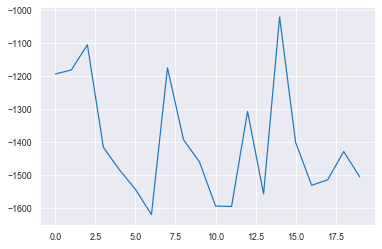

21 -1529.9420578946308 [4.] 4200
22 -1617.3875676648972 [4.] 4400
23 -1500.0154343009729 [4.] 4600
24 -1162.0536535993565 [4.] 4800
25 -1046.9171756685262 [4.] 5000
26 -1475.728333417229 [4.] 5200
27 -1600.2087783636503 [4.] 5400
28 -1500.5388247474643 [4.] 5600
29 -1127.5881275850093 [4.] 5800
30 -1557.8225123297984 [4.] 6000
30 -1404.105516902312


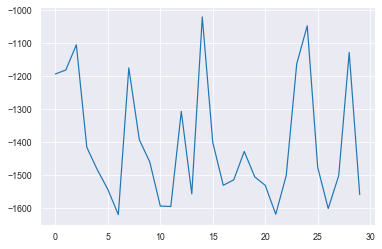

31 -1516.8324015992368 [4.] 6200
32 -1528.311136769023 [4.] 6400
33 -1414.0814640842807 [4.] 6600
34 -1432.0584334422906 [4.] 6800
35 -1587.3516848484376 [4.] 7000
36 -1380.6895548208004 [4.] 7200
37 -1512.17614127987 [4.] 7400
38 -1104.2436672710487 [4.] 7600
39 -1332.33511355668 [4.] 7800
40 -1513.4797431713832 [4.] 8000
40 -1411.1181211978103


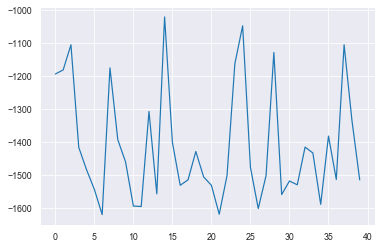

41 -975.4292878086596 [4.] 8200
42 -1298.924296344666 [4.] 8400
43 -1388.098473455999 [4.] 8600
44 -1514.6804819782494 [4.] 8800
45 -1273.9967191895 [4.] 9000
46 -1555.8295502455576 [4.] 9200
47 -1489.979267280685 [4.] 9400
48 -1495.029312590258 [4.] 9600
49 -1477.5023349174385 [4.] 9800
50 -1494.435205538944 [3.996] 10000
50 -1408.1725955452473


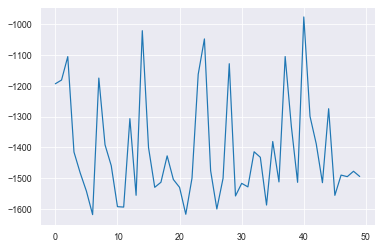

51 -1210.4437983379955 [3.2713287] 10200
52 -1067.9367346139463 [2.6780767] 10400
53 -1233.829932780688 [2.1924098] 10600
54 -1378.6103267925757 [1.7948194] 10800
55 -1460.9430861370165 [1.4693302] 11000
56 -1543.5779024512947 [1.202869] 11200
57 -1338.2207546922912 [0.98472947] 11400
58 -1327.3021583868983 [0.80614966] 11600
59 -1557.8529557050285 [0.65995526] 11800
60 -1198.5367202189461 [0.5402731] 12000
60 -1403.2882877285354


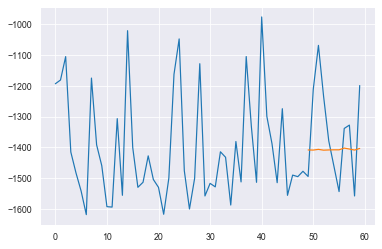

61 -1324.171214377856 [0.44229522] 12200
62 -1618.7632034212756 [0.36208537] 12400
63 -1518.009134985871 [0.29642162] 12600
64 -865.3952953450256 [0.24266596] 12800
65 -1589.6863518224843 [0.19865876] 13000
66 -1220.205229338658 [0.1626322] 13200
67 -1629.2928312860013 [0.13313898] 13400
68 -1003.0574371426197 [0.1089944] 13600
69 -1255.0096924379611 [0.08922836] 13800
70 -1654.6479898286298 [0.07304686] 14000
70 -1387.9831897173522


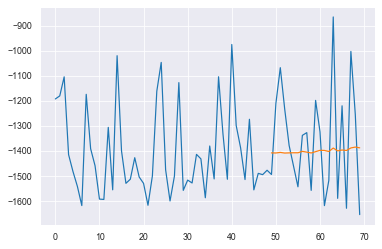

71 -1319.627918490434 [0.05979986] 14200
72 -1636.3439417029629 [0.04895522] 14400
73 -1407.9430282484093 [0.04007723] 14600
74 -835.6402974741729 [0.03280927] 14800
75 -1548.459878118475 [0.02685933] 15000
76 -1495.0867225217414 [0.02198842] 15200
77 -1448.8967836118761 [0.01800085] 15400
78 -1298.8245747476305 [0.01473642] 15600
79 -1263.673108135482 [0.01206399] 15800
80 -1453.1143719156266 [0.0098762] 16000
80 -1379.7713529052573


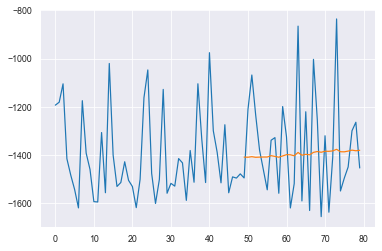

81 -1338.1312865766795 [0.00808515] 16200
82 -1391.754818395314 [0.00661892] 16400
83 -1277.4299574179113 [0.00541858] 16600
84 -1449.3275288548016 [0.00443593] 16800
85 -1501.9884564518948 [0.00363148] 17000
86 -1523.7263347973253 [0.00297291] 17200
87 -1263.2463916458828 [0.00243378] 17400
88 -1275.0905131798158 [0.00199241] 17600
89 -1347.3313007005086 [0.00163109] 17800
90 -1220.9632435288183 [0.00133529] 18000
90 -1365.1199627193755


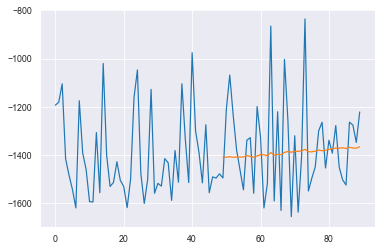

91 -1505.4005349707143 [0.00109314] 18200
92 -1460.4087208935068 [0.0008949] 18400
93 -945.2083696662779 [0.00073261] 18600
94 -1497.414270684962 [0.00059975] 18800
95 -1332.829775933556 [0.00049099] 19000
96 -1070.6024583589983 [0.00040195] 19200
97 -1508.2283748967268 [0.00032905] 19400
98 -986.0117226859298 [0.00026938] 19600
99 -764.7498923286134 [0.00022053] 19800
100 -959.3570171747162 [0.00018054] 20000
100 -1326.4460868842566


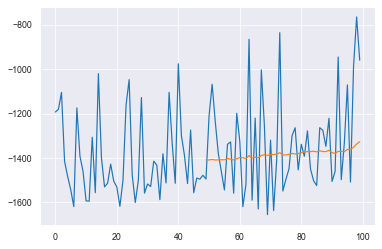

101 -990.8633052791223 [0.0001478] 20200
102 -758.9316007203043 [0.00012099] 20400
103 -942.9093619481237 [9.905144e-05] 20600
104 -752.7992150384398 [8.1088576e-05] 20800
105 -1008.4382350530375 [6.638322e-05] 21000
106 -1051.7062529596026 [5.434466e-05] 21200
107 -960.4321068489833 [4.448929e-05] 21400
108 -902.9945420875356 [3.642119e-05] 21600
109 -757.7298340995017 [2.981625e-05] 21800
110 -1237.6704130865785 [2.4409093e-05] 22000
110 -1247.3904968243476


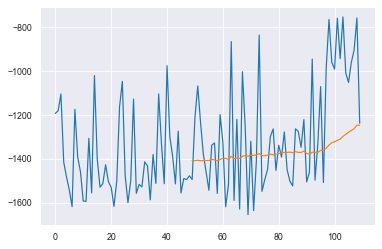

111 -781.0900660539561 [1.9982537e-05] 22200
112 -890.7188340701887 [1.6358732e-05] 22400
113 -1017.5555644733028 [1.3392086e-05] 22600
114 -754.9769906591395 [1.0963444e-05] 22800
115 -1029.3167217801772 [1.e-05] 23000
116 -1504.8940569486206 [1.e-05] 23200
117 -1022.8702582911682 [1.e-05] 23400
118 -1169.119760304659 [1.e-05] 23600
119 -1164.5430832970403 [1.e-05] 23800
120 -1157.3753976792386 [1.e-05] 24000
120 -1183.6749438957697


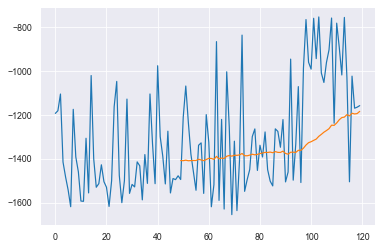

121 -1014.5018423753917 [1.e-05] 24200
122 -1370.1048666504096 [1.e-05] 24400
123 -1257.9476832971905 [1.e-05] 24600
124 -987.3321724816539 [1.e-05] 24800
125 -1203.991706152081 [1.e-05] 25000
126 -1032.935324652088 [1.e-05] 25200
127 -1088.144594413754 [1.e-05] 25400
128 -951.5881678592783 [1.e-05] 25600
129 -1515.896782385407 [1.e-05] 25800
130 -917.358244666464 [1.e-05] 26000
130 -1136.3187590951077


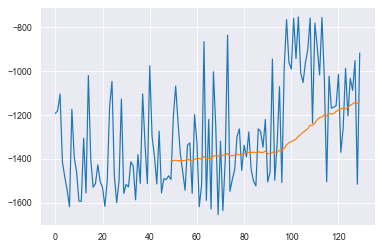

131 -1151.7777225238779 [1.e-05] 26200
132 -1151.5764356762857 [1.e-05] 26400
133 -1492.5532234820428 [1.e-05] 26600
134 -868.4710846814945 [1.e-05] 26800
135 -999.2608247870619 [1.e-05] 27000
136 -1056.7409956260628 [1.e-05] 27200
137 -1371.4882838101955 [1.e-05] 27400
138 -1124.3005867216082 [1.e-05] 27600
139 -1153.178417539199 [1.e-05] 27800
140 -894.4139356479286 [1.e-05] 28000
140 -1089.814192674044


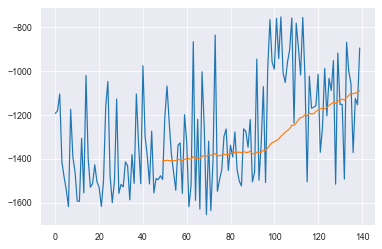

141 -879.1385254670006 [1.e-05] 28200
142 -1147.1113014148011 [1.e-05] 28400
143 -1493.9293034116174 [1.e-05] 28600
144 -1034.4684769744597 [1.e-05] 28800
145 -887.062819176228 [1.e-05] 29000
146 -1121.8473236522902 [1.e-05] 29200
147 -1239.863743255948 [1.e-05] 29400
148 -1020.9031176975116 [1.e-05] 29600
149 -894.1459240741319 [1.e-05] 29800
150 -1069.607663600165 [1.e-05] 30000
150 -1064.971533896647


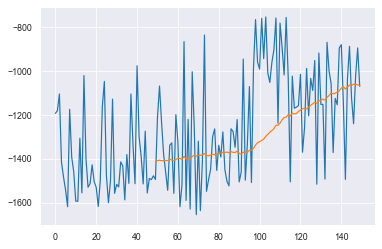

151 -1032.1353601829078 [1.e-05] 30200
152 -873.2955435416995 [1.e-05] 30400
153 -916.175767898167 [1.e-05] 30600
154 -1498.2267585102647 [1.e-05] 30800
155 -1012.9648446252627 [1.e-05] 31000
156 -869.1619986492307 [1.e-05] 31200
157 -1141.7577000039241 [1.e-05] 31400
158 -928.9825052537666 [1.e-05] 31600
159 -1070.586422679375 [1.e-05] 31800
160 -993.5487775285824 [1.e-05] 32000
160 -1084.418750131686


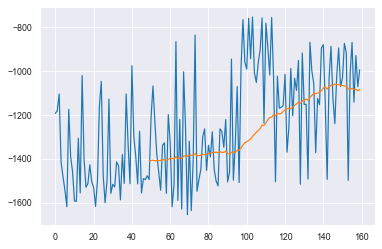

161 -970.1747550867537 [1.e-05] 32200
162 -1008.9615997204045 [1.e-05] 32400
163 -895.200446646998 [1.e-05] 32600
164 -1034.744229907223 [1.e-05] 32800
165 -1118.831952411568 [1.e-05] 33000
166 -1014.2319295728487 [1.e-05] 33200
167 -972.5199358610469 [1.e-05] 33400
168 -895.1500731436221 [1.e-05] 33600
169 -883.0655346839629 [1.e-05] 33800
170 -894.6526185348386 [1.e-05] 34000
170 -1068.3201969719216


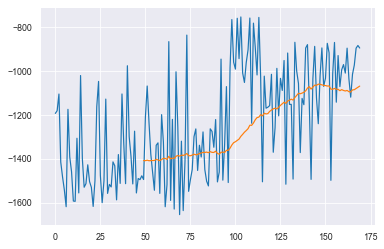

171 -1161.883868988215 [1.e-05] 34200
172 -1002.9018291770373 [1.e-05] 34400
173 -1177.1453887647338 [1.e-05] 34600
174 -1051.4197408090108 [1.e-05] 34800
175 -1141.924972826708 [1.e-05] 35000
176 -894.2756985448785 [1.e-05] 35200
177 -961.2882097126221 [1.e-05] 35400
178 -1097.099026511275 [1.e-05] 35600
179 -1072.296177158332 [1.e-05] 35800
180 -871.7742690216444 [1.e-05] 36000
180 -1050.1643529035364


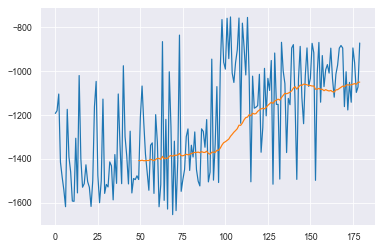

181 -760.0885516401128 [1.e-05] 36200
182 -845.3073673563764 [1.e-05] 36400
183 -1048.9470699044948 [1.e-05] 36600
184 -1147.4408777837914 [1.e-05] 36800
185 -908.6746596453785 [1.e-05] 37000
186 -1222.644775031465 [1.e-05] 37200
187 -1226.808843613773 [1.e-05] 37400
188 -1040.4335615178977 [1.e-05] 37600
189 -1105.9616882178586 [1.e-05] 37800
190 -1103.0059829271597 [1.e-05] 38000
190 -1033.0753902463873


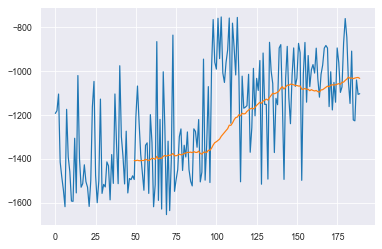

191 -875.7457688052186 [1.e-05] 38200
192 -962.2745815761751 [1.e-05] 38400
193 -1394.8486417586953 [1.e-05] 38600
194 -736.5242925255482 [1.e-05] 38800
195 -1086.923199159837 [1.e-05] 39000
196 -930.2780276171653 [1.e-05] 39200
197 -970.6602311840186 [1.e-05] 39400
198 -1598.455431453244 [1.e-05] 39600
199 -1184.1241866035145 [1.e-05] 39800
200 -1123.8147807012342 [1.e-05] 40000
200 -1034.5868090995973


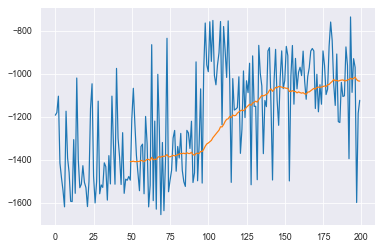

201 -1042.3337760698907 [1.e-05] 40200
202 -1116.5553325801193 [1.e-05] 40400
203 -1313.1486155032928 [1.e-05] 40600
204 -1043.0650374713045 [1.e-05] 40800
205 -1129.7608603445774 [1.e-05] 41000
206 -1135.905884154245 [1.e-05] 41200
207 -1065.4571313813744 [1.e-05] 41400
208 -1134.0044969280577 [1.e-05] 41600
209 -1067.2901143946244 [1.e-05] 41800
210 -1039.2641999851023 [1.e-05] 42000
210 -1049.5858044983854


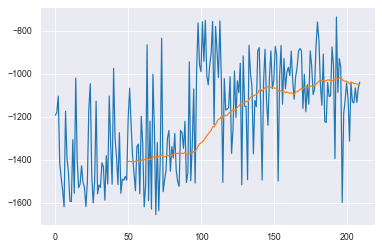

211 -1142.0751121149517 [1.e-05] 42200
212 -1041.9580482895906 [1.e-05] 42400
213 -1028.5882154538763 [1.e-05] 42600
214 -1018.5876572797885 [1.e-05] 42800
215 -1234.4996012104523 [1.e-05] 43000
216 -1254.2478171059402 [1.e-05] 43200
217 -1160.5595813746381 [1.e-05] 43400
218 -1168.8225879252511 [1.e-05] 43600
219 -902.6790936905431 [1.e-05] 43800
220 -1140.6511730240843 [1.e-05] 44000
220 -1077.6885207363825


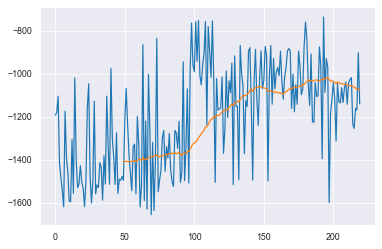

221 -962.1117176924143 [1.e-05] 44200
222 -1207.5523473133394 [1.e-05] 44400
223 -1097.0486008021164 [1.e-05] 44600
224 -1197.696843611889 [1.e-05] 44800
225 -1175.5301547409686 [1.e-05] 45000
226 -1021.3966578974107 [1.e-05] 45200
227 -1054.0582481599683 [1.e-05] 45400
228 -659.3907802283061 [1.e-05] 45600
229 -1377.1982738861298 [1.e-05] 45800
230 -1513.5609504088895 [1.e-05] 46000
230 -1094.3592286009218


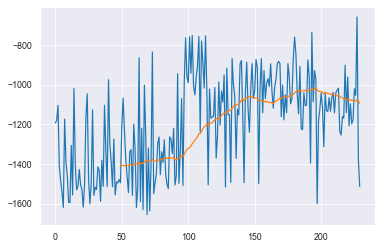

231 -1236.5231847734653 [1.e-05] 46200
232 -1261.5751031354914 [1.e-05] 46400
233 -1158.431104338329 [1.e-05] 46600
234 -1184.6065737710055 [1.e-05] 46800
235 -1240.931646616587 [1.e-05] 47000
236 -1101.694666073853 [1.e-05] 47200
237 -1096.210949723078 [1.e-05] 47400
238 -1471.4140160241943 [1.e-05] 47600
239 -1389.8524952304806 [1.e-05] 47800
240 -1208.7677362751817 [1.e-05] 48000
240 -1133.173110567389


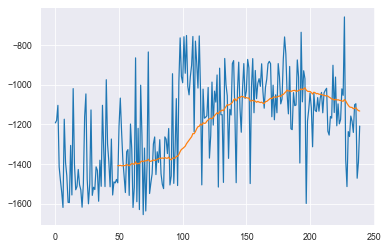

241 -1032.489637258975 [1.e-05] 48200
242 -1168.336451560626 [1.e-05] 48400
243 -1300.3221396244744 [1.e-05] 48600
244 -1226.9854171023417 [1.e-05] 48800
245 -1193.058165039537 [1.e-05] 49000
246 -1229.4438768811688 [1.e-05] 49200
247 -1169.1827124628949 [1.e-05] 49400
248 -1173.5138422928928 [1.e-05] 49600
249 -1166.8299292905729 [1.e-05] 49800
250 -1064.16450422358 [1.e-05] 50000
250 -1150.3866612544375


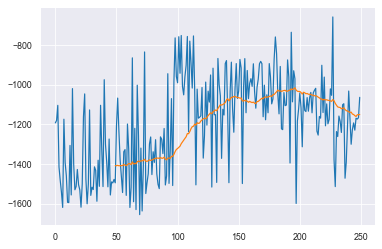

251 -1130.0403239686968 [1.e-05] 50200
252 -1326.088984891616 [1.e-05] 50400
253 -1633.7242753102244 [1.e-05] 50600
254 -1536.7642399919084 [1.e-05] 50800
255 -1037.1767333634943 [1.e-05] 51000
256 -1422.7105428717166 [1.e-05] 51200
257 -1349.8844313394457 [1.e-05] 51400
258 -1545.7468514639922 [1.e-05] 51600
259 -1513.5586829312886 [1.e-05] 51800
260 -1307.2475481399301 [1.e-05] 52000
260 -1204.709804563632


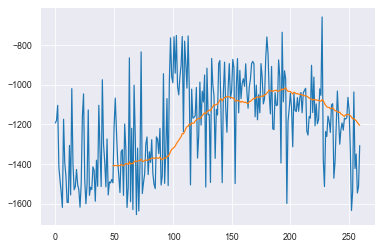

261 -1503.4577055231578 [1.e-05] 52200
262 -1171.7563311854715 [1.e-05] 52400
263 -1062.3379376728203 [1.e-05] 52600
264 -1250.442538370386 [1.e-05] 52800
265 -1070.549536334421 [1.e-05] 53000
266 -1160.4588596685287 [1.e-05] 53200
267 -1207.848131852154 [1.e-05] 53400
268 -1120.3663734002776 [1.e-05] 53600
269 -1281.0188027641893 [1.e-05] 53800
270 -1067.4856197875451 [1.e-05] 54000
270 -1220.7708635454285


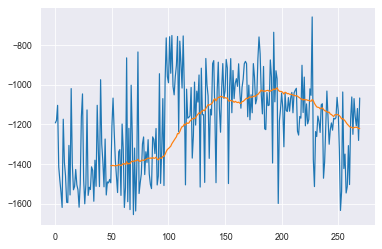

271 -1293.1765194793954 [1.e-05] 54200
272 -744.6367862832367 [1.e-05] 54400
273 -1198.1506753603064 [1.e-05] 54600
274 -1167.319822298424 [1.e-05] 54800
275 -1261.4277980649417 [1.e-05] 55000
276 -1200.4315859975445 [1.e-05] 55200
277 -1168.4869906061065 [1.e-05] 55400
278 -1242.5831927581812 [1.e-05] 55600
279 -1135.5281742590967 [1.e-05] 55800
280 -1253.0184380604383 [1.e-05] 56000
280 -1228.7551717139534


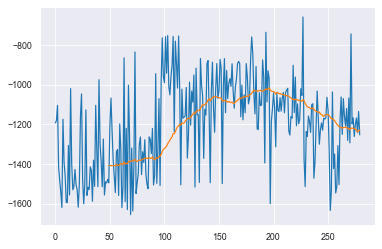

281 -1189.6720395977381 [1.e-05] 56200
282 -1172.3372435814513 [1.e-05] 56400
283 -1031.5741378804078 [1.e-05] 56600
284 -884.0504521574784 [1.e-05] 56800
285 -758.0394722229192 [1.e-05] 57000
286 -1251.7418473973419 [1.e-05] 57200
287 -883.870542778898 [1.e-05] 57400
288 -764.4639340500744 [1.e-05] 57600
289 -1030.7736051285112 [1.e-05] 57800
290 -945.0914615521757 [1.e-05] 58000
290 -1179.9873169216598


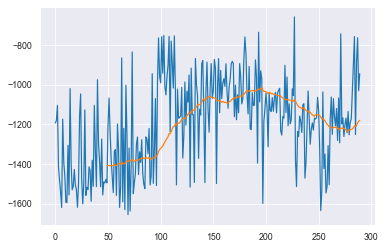

291 -1309.3748456962903 [1.e-05] 58200
292 -1213.8176069546735 [1.e-05] 58400
293 -1042.5983772800846 [1.e-05] 58600
294 -1054.497336630327 [1.e-05] 58800
295 -1134.583501665062 [1.e-05] 59000
296 -1622.0215748100045 [1.e-05] 59200
297 -1347.0225148246207 [1.e-05] 59400
298 -955.8412599527696 [1.e-05] 59600
299 -1598.243953629001 [1.e-05] 59800
300 -1197.8889968126039 [1.e-05] 60000
300 -1195.0185827720275


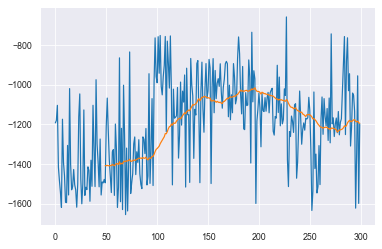

301 -1532.361829989395 [1.e-05] 60200
302 -1300.1652317870467 [1.e-05] 60400
303 -1504.893315206606 [1.e-05] 60600
304 -1402.363024437943 [1.e-05] 60800
305 -1294.4338715818653 [1.e-05] 61000
306 -885.8051826065852 [1.e-05] 61200
307 -693.9717446371238 [1.e-05] 61400
308 -1311.1031408614838 [1.e-05] 61600
309 -1193.8106784968322 [1.e-05] 61800
310 -1155.969025463344 [1.e-05] 62000
310 -1164.4572713879456


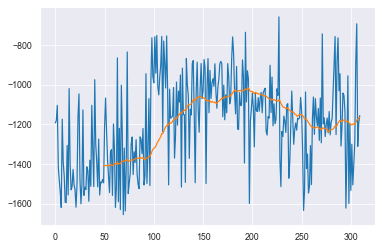

311 -1002.4532354009885 [1.e-05] 62200
312 -962.2014225576664 [1.e-05] 62400
313 -1043.9198818809584 [1.e-05] 62600
314 -1184.910404623623 [1.e-05] 62800
315 -1143.4596427366303 [1.e-05] 63000
316 -1096.2303602164445 [1.e-05] 63200
317 -1126.32195840424 [1.e-05] 63400
318 -1172.5193598542091 [1.e-05] 63600
319 -1392.9050692032463 [1.e-05] 63800
320 -1190.093629752588 [1.e-05] 64000
320 -1152.8431339493786


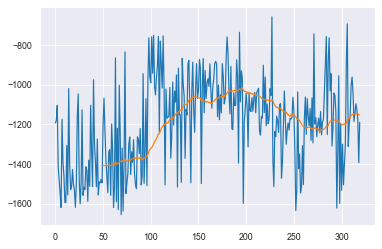

321 -1140.7266860742557 [1.e-05] 64200
322 -1024.7832106706862 [1.e-05] 64400
323 -1201.9484373562134 [1.e-05] 64600
324 -1018.7195805531525 [1.e-05] 64800
325 -960.5448091306984 [1.e-05] 65000
326 -1113.9108346464568 [1.e-05] 65200
327 -906.4089368787652 [1.e-05] 65400
328 -1205.523684845571 [1.e-05] 65600
329 -1312.408268653175 [1.e-05] 65800
330 -1003.8083203009068 [1.e-05] 66000
330 -1137.3235896682227


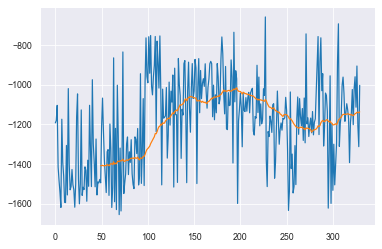

331 -1154.8518341148952 [1.e-05] 66200
332 -1016.3565386767945 [1.e-05] 66400
333 -1303.8825473125473 [1.e-05] 66600
334 -1318.216080350481 [1.e-05] 66800
335 -1329.1445222355976 [1.e-05] 67000
336 -972.8952159364854 [1.e-05] 67200
337 -1222.1320366904706 [1.e-05] 67400
338 -1275.9383235689002 [1.e-05] 67600
339 -1188.7837428754262 [1.e-05] 67800
340 -1064.390549989241 [1.e-05] 68000
340 -1176.0231227762995


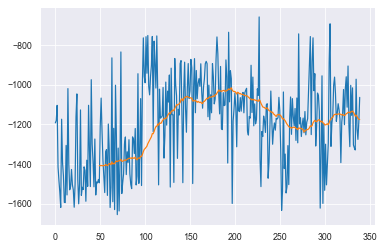

341 -1295.4939317628755 [1.e-05] 68200
342 -1571.4011332456935 [1.e-05] 68400
343 -1296.6977755759367 [1.e-05] 68600
344 -988.8285766494563 [1.e-05] 68800
345 -739.7649649104397 [1.e-05] 69000
346 -1024.0143714693127 [1.e-05] 69200
347 -1008.2249262284963 [1.e-05] 69400
348 -1032.8879127312957 [1.e-05] 69600
349 -879.2368460016628 [1.e-05] 69800
350 -1317.982914610616 [1.e-05] 70000
350 -1149.5959904749066


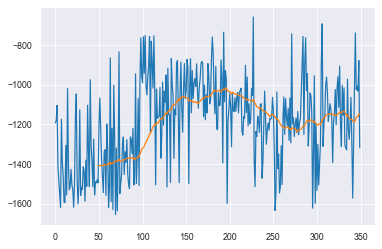

351 -1336.400465471872 [1.e-05] 70200
352 -1042.5991251024427 [1.e-05] 70400
353 -1134.4296001058276 [1.e-05] 70600
354 -1084.0967451126837 [1.e-05] 70800
355 -668.2867181853748 [1.e-05] 71000
356 -828.6410953413791 [1.e-05] 71200
357 -1323.1561617060015 [1.e-05] 71400
358 -892.8096266284778 [1.e-05] 71600
359 -902.4148192146724 [1.e-05] 71800
360 -991.2799699437917 [1.e-05] 72000
360 -1108.1807361097924


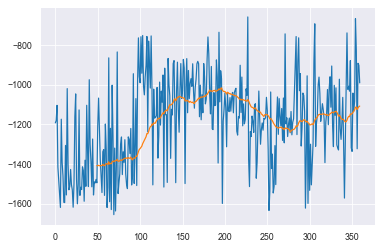

361 -1030.5355718887738 [1.e-05] 72200
362 -1039.2678860593155 [1.e-05] 72400
363 -962.1799072276377 [1.e-05] 72600
364 -920.8298466765389 [1.e-05] 72800
365 -962.5231539646552 [1.e-05] 73000
366 -860.7097113894555 [1.e-05] 73200
367 -958.2392563007725 [1.e-05] 73400
368 -1128.3485909088895 [1.e-05] 73600
369 -1023.830163104267 [1.e-05] 73800
370 -933.1136185096481 [1.e-05] 74000
370 -1078.2719909377797


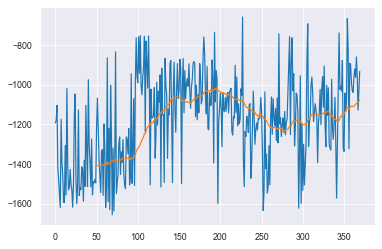

371 -1303.0248065947133 [1.e-05] 74200
372 -936.2744077673245 [1.e-05] 74400
373 -1031.5551299566487 [1.e-05] 74600
374 -910.0156238615459 [1.e-05] 74800
375 -1053.9723312588526 [1.e-05] 75000
376 -844.3088379462106 [1.e-05] 75200
377 -1072.4918257570098 [1.e-05] 75400
378 -1036.3709117002156 [1.e-05] 75600
379 -1505.5740394464813 [1.e-05] 75800
380 -999.8073999763945 [1.e-05] 76000
380 -1074.36424184089


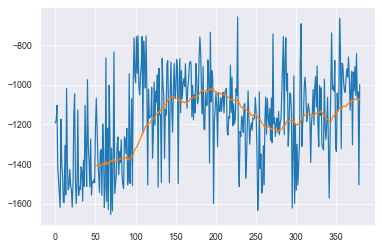

381 -1146.6853882274788 [1.e-05] 76200
382 -1004.5991044411985 [1.e-05] 76400
383 -1212.5262019246122 [1.e-05] 76600
384 -926.1204639165248 [1.e-05] 76800
385 -747.0084370480024 [1.e-05] 77000
386 -940.6796189679851 [1.e-05] 77200
387 -975.8767795747034 [1.e-05] 77400
388 -1312.0046460937795 [1.e-05] 77600
389 -891.2368773628697 [1.e-05] 77800
390 -882.1376219711148 [1.e-05] 78000
390 -1038.2099167964384


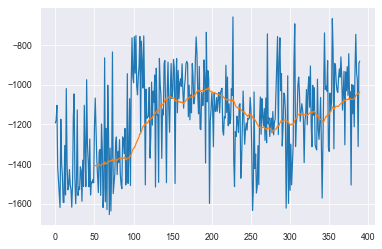

391 -860.0384144408915 [1.e-05] 78200
392 -1084.8892313252347 [1.e-05] 78400
393 -1149.1422081135697 [1.e-05] 78600
394 -960.8326840284224 [1.e-05] 78800
395 -877.6837780654463 [1.e-05] 79000
396 -886.4944742910992 [1.e-05] 79200
397 -848.8710301004919 [1.e-05] 79400
398 -825.9673313009084 [1.e-05] 79600
399 -666.8608827274664 [1.e-05] 79800
400 -730.724329918277 [1.e-05] 80000
400 -992.9493370189589


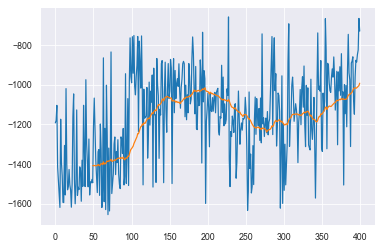

401 -1206.7932877815235 [1.e-05] 80200
402 -1028.4926093531042 [1.e-05] 80400
403 -1015.227807070749 [1.e-05] 80600
404 -1030.8615286390311 [1.e-05] 80800
405 -1030.8129950103921 [1.e-05] 81000
406 -1005.8080679386793 [1.e-05] 81200
407 -886.3134401531462 [1.e-05] 81400
408 -754.0782957439202 [1.e-05] 81600
409 -1097.0823455776583 [1.e-05] 81800
410 -730.6403102403581 [1.e-05] 82000
410 -984.5892642328796


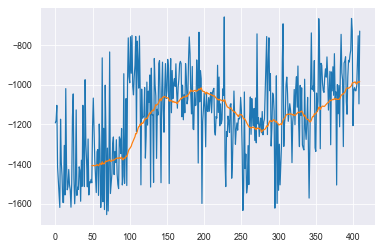

411 -862.2491005945678 [1.e-05] 82200
412 -895.9632382823985 [1.e-05] 82400
413 -633.0189922091021 [1.e-05] 82600
414 -383.2916688014935 [1.e-05] 82800
415 -764.1670906450637 [1.e-05] 83000
416 -874.08576960507 [1.e-05] 83200
417 -767.8386664946762 [1.e-05] 83400
418 -852.6371898598046 [1.e-05] 83600
419 -881.9832698481767 [1.e-05] 83800
420 -813.9691867678479 [1.e-05] 84000
420 -942.7817935744449


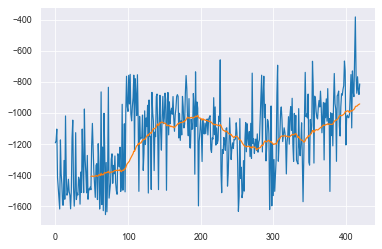

421 -867.1978448117004 [1.e-05] 84200
422 -1017.9665131064774 [1.e-05] 84400
423 -1156.1831140836316 [1.e-05] 84600
424 -1109.0802164513605 [1.e-05] 84800
425 -1332.3107924929761 [1.e-05] 85000
426 -1378.3334520060557 [1.e-05] 85200
427 -902.3144510306156 [1.e-05] 85400
428 -1167.2850279893214 [1.e-05] 85600
429 -1335.6602492349011 [1.e-05] 85800
430 -617.9274567786608 [1.e-05] 86000
430 -946.599069648851


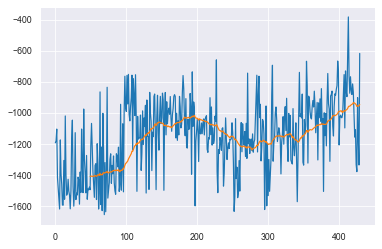

431 -1037.3300048458862 [1.e-05] 86200
432 -898.1852899266489 [1.e-05] 86400
433 -1161.5144576112555 [1.e-05] 86600
434 -892.5737945551297 [1.e-05] 86800
435 -906.0694745632453 [1.e-05] 87000
436 -881.8886538544991 [1.e-05] 87200
437 -1007.2739040597119 [1.e-05] 87400
438 -767.7348019363506 [1.e-05] 87600
439 -635.164275505553 [1.e-05] 87800
440 -695.7756912753636 [1.e-05] 88000
440 -923.4917738209582


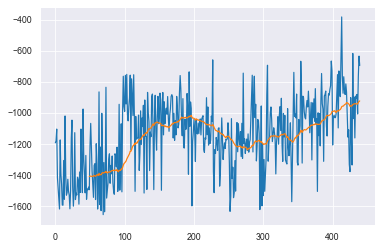

441 -511.1688329934423 [1.e-05] 88200
442 -610.7314303179858 [1.e-05] 88400
443 -836.4775714997365 [1.e-05] 88600
444 -626.9438535625628 [1.e-05] 88800
445 -827.5913980801238 [1.e-05] 89000
446 -725.4003168815592 [1.e-05] 89200
447 -743.3365105100143 [1.e-05] 89400
448 -504.09417450823287 [1.e-05] 89600
449 -132.49832148867904 [1.e-05] 89800
450 -136.45861443158753 [1.e-05] 90000
450 -858.7557070202008


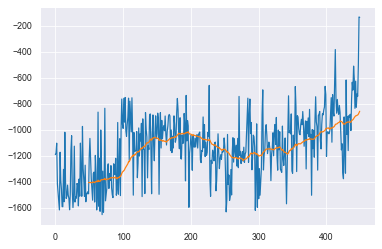

451 -835.5042241673516 [1.e-05] 90200
452 -245.24303512351122 [1.e-05] 90400
453 -379.22782102418176 [1.e-05] 90600
454 -986.8258873790666 [1.e-05] 90800
455 -644.5420057772998 [1.e-05] 91000
456 -993.9868687392035 [1.e-05] 91200
457 -497.02811621777175 [1.e-05] 91400
458 -495.46527868952217 [1.e-05] 91600
459 -778.4651268183508 [1.e-05] 91800
460 -513.4091528317297 [1.e-05] 92000
460 -790.4274436053892


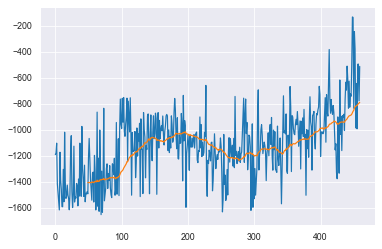

461 -2.0908967993951593 [1.e-05] 92200
462 -608.9746312417467 [1.e-05] 92400
463 -246.797803649985 [1.e-05] 92600
464 -527.971447873744 [1.e-05] 92800
465 -1073.9022501343738 [1.e-05] 93000
466 -854.2399264577858 [1.e-05] 93200
467 -759.22506252796 [1.e-05] 93400
468 -615.5916159557272 [1.e-05] 93600
469 -127.00449430024463 [1.e-05] 93800
470 -355.452308921701 [1.e-05] 94000
470 -739.2683689004784


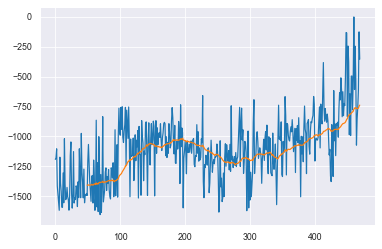

471 -738.2870725906084 [1.e-05] 94200
472 -942.0733869423686 [1.e-05] 94400
473 -620.2731418633733 [1.e-05] 94600
474 -492.65776240447684 [1.e-05] 94800
475 -115.78024232093648 [1.e-05] 95000
476 -0.867030910665433 [1.e-05] 95200
477 -229.54735570123046 [1.e-05] 95400
478 -753.2479286308859 [1.e-05] 95600
479 -2.440746956838724 [1.e-05] 95800
480 -569.9850945748628 [1.e-05] 96000
480 -610.8863817986894


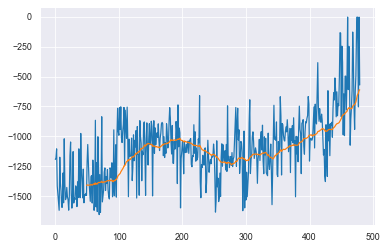

481 -243.75853168555312 [1.e-05] 96200
482 -495.0204148230025 [1.e-05] 96400
483 -123.1298415453547 [1.e-05] 96600
484 -750.3009094642167 [1.e-05] 96800
485 -493.5140263702198 [1.e-05] 97000
486 -121.88176605819127 [1.e-05] 97200
487 -127.0745905570245 [1.e-05] 97400
488 -235.32648340148097 [1.e-05] 97600
489 -3.310287779817651 [1.e-05] 97800
490 -489.2600662738202 [1.e-05] 98000
490 -494.8677131951901


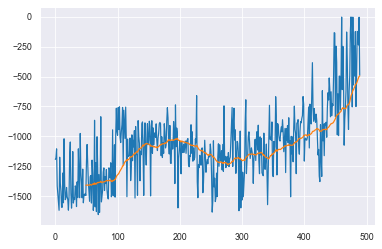

491 -121.53695000206132 [1.e-05] 98200
492 -6.308860788529098 [1.e-05] 98400
493 -0.7358251704766641 [1.e-05] 98600
494 -121.80545941793471 [1.e-05] 98800
495 -5.960936267301338 [1.e-05] 99000
496 -128.45346590423597 [1.e-05] 99200
497 -255.70929123093183 [1.e-05] 99400
498 -421.0967789446881 [1.e-05] 99600
499 -2.7902262606213406 [1.e-05] 99800
500 -120.49577442550655 [1.e-05] 100000
500 -405.47156407795745


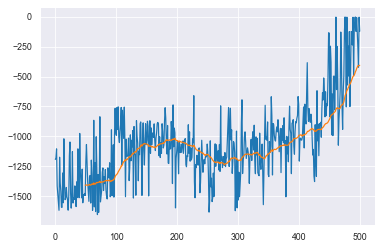

In [10]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=3e-3
agent_config['alpha_critic']=3e-3
agent_config['structure_actor']=[32,16]
agent_config['structure_critic']=[32,16]
agent_config['memory_size']=1e7
agent_config['batch_size']=32

agent_config['update_freq']=1
agent_config['sigma_decay']=0.999
agent_config['polyak']=0.99

agent_config['pure_explore_step']=10000
agent_config['start_learning_step']=5000
agent_config['policy_delay']=2


agent=TD3(agent_config)

Iter=500
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    while not done:
        a = agent.get_actions(s.reshape(1,-1))[0]
        sp, r, done, info = env.step(a)
        agent.memorize(s,a,r,sp,done)
        agent.learn()
        s = sp
        G+=r
    G_log.append(G)
    print(len(G_log),G,agent.sigma,len(agent.memory))
    if (epoch+1)%10==0:
        print(len(G_log),np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()  

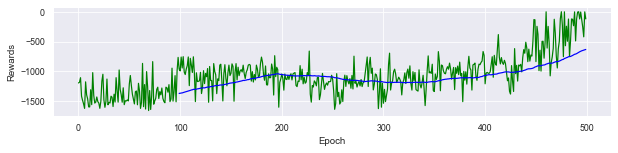

In [11]:
plt.figure(figsize=(10,2))
plt.plot(G_log,c="green")
plt.plot(pd.DataFrame(G_log).rolling(int(len(G_log)/5)).mean(),c="blue")
plt.xlabel("Epoch")
plt.ylabel("Rewards")
plt.show()